## Plotting ISCO sample inventory over winter 2023 discharge

### Discharge data from Satish in sonya-may2024 directory

## TO DO:

- [x] the datetime combination in Section 3 is very ugly but functional, make that more efficient
- [x] add in met data
- [ ] reverse hyteograph x axis
- [ ] put term for x axis scale label breaks into plot function

Rows: 138 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (9): Sample ID, Site, Date, Type, Index-notes, ICP-notes, IC-notes, NR...
dbl  (20): Fe_mg_L, Mn_mg_L, Cu_mg_L, Zn_mg_L, Si_mg_L, K_mg_L, P_mg_L, Mg_m...
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time Zone"))`.
Caused by warning:
!  3 failed to parse.”
Rows: 77548 Columns: 17
── Column specification ────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): type, NO3_source, TP_source, TDP_source, PP_source, SRP_source
dbl  (10): q_cms_hb, q_cms_mb, q_cms_pred, q_cms_hb_filled, NO3, year, TP, T...
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full colu

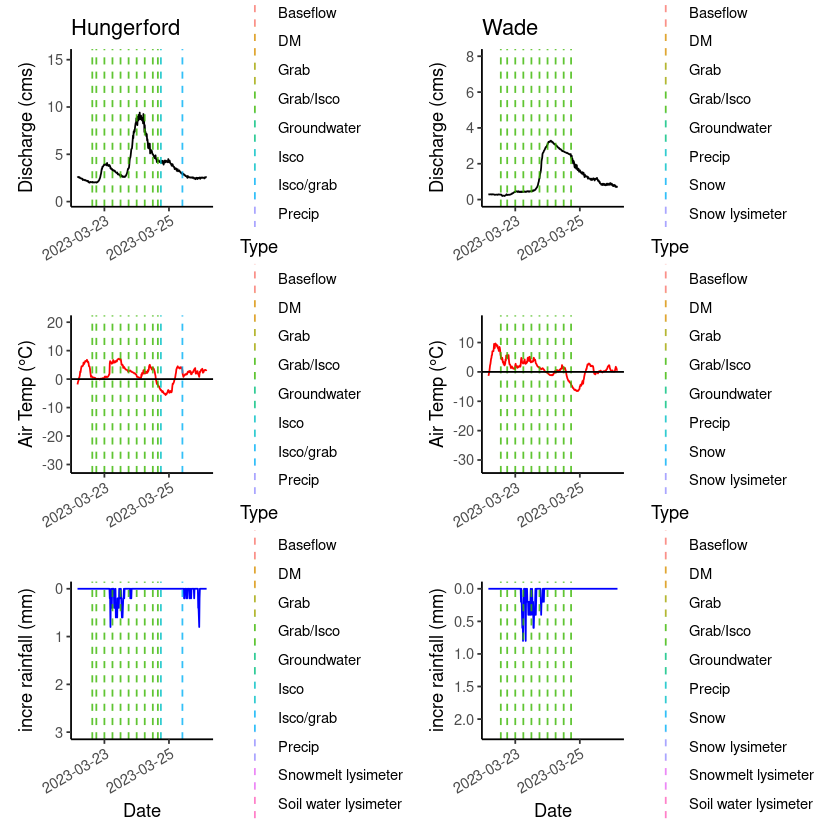

In [7]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data
library(patchwork)

###################
# SET DIRECTORIES #
###################

q_input_dir <- "~//OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data"
c_input_dir <- "~//OneDrive/git-repos/EMMA/isco_metadata/LCBP_RI_sample_index/"
m_input_dir <- "~//OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/"
output_dir <- "~//OneDrive/git-repos/EMMA/output/"

##########################
# READ IN AND CLEAN DATA #
##########################

# read in the RI23 data
# see joining here: 
# https://github.com/MeganEDuffy/EMMA/blob/main/isco_metadata/LCBP_RI_sample_index/RI23-sample-ID-join.ipynb
MetadataISCO <- read_csv(file.path(c_input_dir, "RI23-IC-ICP-isotope-joined.csv")) #%>%
    #filter(Site == 'Hungerford')

# Convert the "Date" column to date format and Time to time format
MetadataISCO$Date <- mdy(MetadataISCO$Date)  # mdy() parses dates in "month/day/year" format 

# Combine Date, Time, and Time zone columns into a single Datetime column
MetadataISCO <- MetadataISCO %>%
  mutate(Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time Zone")))

# Read in the q data
Hungerford_q <- read_csv(file.path(q_input_dir, "hb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_hb)
Wade_q <- read_csv(file.path(q_input_dir, "wb_q_chem.csv")) %>%
  mutate(q_cms = q_cms_wb)

# Read in the met data for air temp
Hungerford_m <- read_csv(file.path(m_input_dir, "hungerford_2020-2024_met_2024-11-08.csv")) %>%
  filter(Timestamp > as.Date("2023-01-01 00:00:00"), 
        Timestamp < as.Date("2023-04-20 00:00:00")) %>%
  mutate(Stream = "Hungerford")
  
Wade_m <- read_csv(file.path(m_input_dir, "wade_2020-2024_met_2024-11-08.csv")) %>%
  filter(Timestamp > as.Date("2023-01-01 00:00:00"), 
        Timestamp < as.Date("2023-04-20 00:00:00")) %>%
  mutate(Stream = "Wade")

# Remove rows with NA for Air_Temp for Wade and Precip
Wade_m_clean <- Wade_m %>% filter(!is.na(Air_Temp))
Wade_m_clean <- Wade_m %>% filter(!is.na(Precip_Increm))

#################################
# PLOT HYDROGRAPH AND HYTEOGRAPHS
#################################

# Define time ranges for events
event_a_range <- c(as.POSIXct("2023-02-06"), as.POSIXct("2023-02-18"))
event_c_range <- c(as.POSIXct("2023-03-22"), as.POSIXct("2023-03-26"))
event_d_range <- c(as.POSIXct("2023-03-28"), as.POSIXct("2023-04-14"))
entire_winter <- c(as.POSIXct("2023-01-01"), as.POSIXct("2023-04-25"))

# Choose event range to view 
#selected_range <- event_a_range
#selected_range <- entire_winter
selected_range <- event_c_range
#selected_range <- event_d_range


# Create a function to generate plots with vertical lines
create_stream_plots <- function(q_data, met_data, meta_data, stream_name, time_range) {
  # Filter MetadataISCO for the specific stream
  stream_meta <- meta_data %>% filter(Site == stream_name)
  
  discharge_plot <- ggplot(q_data) +
    geom_line(aes(x = datetime, y = q_cms), color = "black") +
    geom_vline(data = stream_meta, aes(xintercept = Datetime, color = Type), linetype = "dashed", alpha = 0.8) +
    labs(title = paste(stream_name), y = "Discharge (cms)", x = NULL) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    scale_x_datetime(limits = time_range, date_labels = "%Y-%m-%d", date_breaks = "2 days")
    #scale_x_datetime(limits = time_range, date_labels = "%Y-%m-%d", date_breaks = "2 weeks")
  
  temp_plot <- ggplot(met_data) +
    geom_line(aes(x = Timestamp, y = Air_Temp), color = "red") +
    geom_vline(data = stream_meta, aes(xintercept = Datetime, color = Type), linetype = "dashed", alpha = 0.8) +
    labs(title = "", y = "Air Temp (°C)", x = NULL) +
    geom_hline(yintercept=0) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    scale_x_datetime(limits = time_range, date_labels = "%Y-%m-%d", date_breaks = "2 days")
    #scale_x_datetime(limits = time_range, date_labels = "%Y-%m-%d", date_breaks = "2 weeks")
  
  rain_plot <- ggplot(met_data) +
    geom_line(aes(x = Timestamp, y = Precip_Increm), color = "blue") +
    geom_vline(data = stream_meta, aes(xintercept = Datetime, color = Type), linetype = "dashed", alpha = 0.8) +
    labs(title = "", y = "incre rainfall (mm)", x = "Date") +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    scale_y_reverse() +
    scale_x_datetime(limits = time_range, date_labels = "%Y-%m-%d", date_breaks = "2 days")
    #scale_x_datetime(limits = time_range, date_labels = "%Y-%m-%d", date_breaks = "2 weeks")
  
  # Combine vertically stacked plots
  combined <- discharge_plot / temp_plot / rain_plot
  return(combined)
}

# Generate plots for Hungerford with MetadataISCO
hungerford_combined <- create_stream_plots(
  q_data = Hungerford_q,
  met_data = Hungerford_m,
  meta_data = MetadataISCO,
  stream_name = "Hungerford",
  time_range = selected_range
)

# Generate plots for Wade with MetadataISCO
wade_combined <- create_stream_plots(
  q_data = Wade_q,
  met_data = Wade_m_clean,
  meta_data = MetadataISCO,
  stream_name = "Wade",
  time_range = selected_range
)

# Combine Hungerford and Wade horizontally
final_plot <- hungerford_combined | wade_combined

# Save and display the plot
ggsave(file.path(output_dir, "RI23_event_plot_with_vlines_C.png"), plot = final_plot, width = 14, height = 10, dpi = 500)
print(final_plot)